In [ ]:
# Cell 1 — Imports
import pandas as pd
import matplotlib.pyplot as plt
import io
import re
from IPython.display import display

plt.rcParams['figure.figsize'] = (12,5)

In [ ]:
import pandas as pd
import io
from google.colab import files

# Upload the CSV file
uploaded = files.upload()

# Read the uploaded CSV into a DataFrame
filename = list(uploaded.keys())[0]
data = pd.read_csv(io.BytesIO(uploaded[filename]))

# Show first few rows to confirm
print("Preview of dataset:")
print(data.head())

Saving retail_sales_dataset.csv to retail_sales_dataset (2).csv
Preview of dataset:
   Transaction ID        Date Customer ID  Gender  Age Product Category  \
0               1  24-11-2023     CUST001    Male   34           Beauty   
1               2  27-02-2023     CUST002  Female   26         Clothing   
2               3  13-01-2023     CUST003    Male   50      Electronics   
3               4  21-05-2023     CUST004    Male   37         Clothing   
4               5  06-05-2023     CUST005    Male   30           Beauty   

   Quantity  Price per Unit  Total Amount  
0         3              50           150  
1         2             500          1000  
2         1              30            30  
3         1             500           500  
4         2              50           100  


In [ ]:
# Cell 3 — Read CSV into a DataFrame (robust to small encoding issues)
try:
    # uploaded[filename] is bytes; use BytesIO so pandas can read it
    df = pd.read_csv(io.BytesIO(uploaded[filename]))
except Exception as e:
    print("First read failed, trying fallback read. Error was:", e)
    # fallback: try reading via filename (should also work in Colab)
    df = pd.read_csv(filename, encoding='latin1', engine='python')

print("Data loaded. Number of rows:", len(df))

Data loaded. Number of rows: 1000


In [ ]:
# Cell 4 — Show columns and first rows so you know what the file contains
print("Original columns:", list(df.columns))
display(df.head())

Original columns: ['Transaction ID', 'Date', 'Customer ID', 'Gender', 'Age', 'Product Category', 'Quantity', 'Price per Unit', 'Total Amount']


,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
0,1,24-11-2023,CUST001,Male,34,Beauty,3,50,150
1,2,27-02-2023,CUST002,Female,26,Clothing,2,500,1000
2,3,13-01-2023,CUST003,Male,50,Electronics,1,30,30
3,4,21-05-2023,CUST004,Male,37,Clothing,1,500,500
4,5,06-05-2023,CUST005,Male,30,Beauty,2,50,100


In [ ]:
# Cell 5 — Normalize column names to lowercase_underscore style
def normalize(col):
    col = str(col).strip()
    col = re.sub(r'\s+', ' ', col)            # collapse spaces
    col = re.sub(r'[^\w\s]', '', col)         # remove punctuation
    return col.lower().replace(' ', '_')

df.columns = [normalize(c) for c in df.columns]
print("Normalized columns:", list(df.columns))
display(df.head())

Normalized columns: ['transaction_id', 'date', 'customer_id', 'gender', 'age', 'product_category', 'quantity', 'price_per_unit', 'total_amount']


,transaction_id,date,customer_id,gender,age,product_category,quantity,price_per_unit,total_amount
0,1,24-11-2023,CUST001,Male,34,Beauty,3,50,150
1,2,27-02-2023,CUST002,Female,26,Clothing,2,500,1000
2,3,13-01-2023,CUST003,Male,50,Electronics,1,30,30
3,4,21-05-2023,CUST004,Male,37,Clothing,1,500,500
4,5,06-05-2023,CUST005,Male,30,Beauty,2,50,100


In [ ]:
# Cell 6 — Detect and parse the date column
date_candidates = [c for c in df.columns if 'date' in c]
if not date_candidates:
    raise ValueError("No date-like column found. Columns: " + ", ".join(df.columns))
date_col = date_candidates[0]
print("Using date column:", date_col)

# Parse to datetime; dayfirst=True helps with formats like DD/MM/YYYY
df[date_col] = pd.to_datetime(df[date_col], errors='coerce', dayfirst=True, infer_datetime_format=True)
bad_dates = df[date_col].isna().sum()
print(f"Rows with invalid/unparsed dates: {bad_dates} (these will be dropped).")

# Drop rows with bad dates and sort by date
df = df.dropna(subset=[date_col]).sort_values(by=date_col).reset_index(drop=True)
print("After dropping bad dates, rows:", len(df))

Using date column: date
Rows with invalid/unparsed dates: 0 (these will be dropped).
After dropping bad dates, rows: 1000


/tmp/ipython-input-221171045.py:9: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[date_col] = pd.to_datetime(df[date_col], errors='coerce', dayfirst=True, infer_datetime_format=True)


In [ ]:
# Cell 7 — Detect a sales-like column (try common names, then fallback to numeric)
candidates = ['total_amount','totalamount','total','sales','sales_amount','amount','revenue','price_per_unit','quantity']
sales_col = next((c for c in candidates if c in df.columns), None)

if sales_col is None:
    # try contains check
    for c in df.columns:
        if any(k in c for k in ['amount','total','sales','revenue','price','qty','quantity']):
            sales_col = c
            break

if sales_col is None:
    numeric_cols = df.select_dtypes(include='number').columns.tolist()
    numeric_cols = [c for c in numeric_cols if 'id' not in c]
    if not numeric_cols:
        raise ValueError("Couldn't find any numeric column to use as sales. Columns: " + ", ".join(df.columns))
    sales_col = numeric_cols[-1]
    print("No obvious sales-like column; using numeric fallback:", sales_col)
else:
    print("Detected sales column:", sales_col)

# show a small sample of that column
display(df[[date_col, sales_col]].head())

Detected sales column: total_amount


,date,total_amount
0,2023-01-01,1500
1,2023-01-01,900
2,2023-01-01,1200
3,2023-01-02,90
4,2023-01-02,25


In [ ]:
# Cell 8 — Aggregate transactions to daily totals
daily = df.groupby(date_col, as_index=False)[sales_col].sum().rename(columns={date_col:'date', sales_col:'sales'})
print("Daily aggregated data (first rows):")
display(daily.head())
print("\nDaily data summary:")
print(daily.info())

Daily aggregated data (first rows):


,date,sales
0,2023-01-01,3600
1,2023-01-02,1765
2,2023-01-03,600
3,2023-01-04,1240
4,2023-01-05,1100



Daily data summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345 entries, 0 to 344
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    345 non-null    datetime64[ns]
 1   sales   345 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.5 KB
None


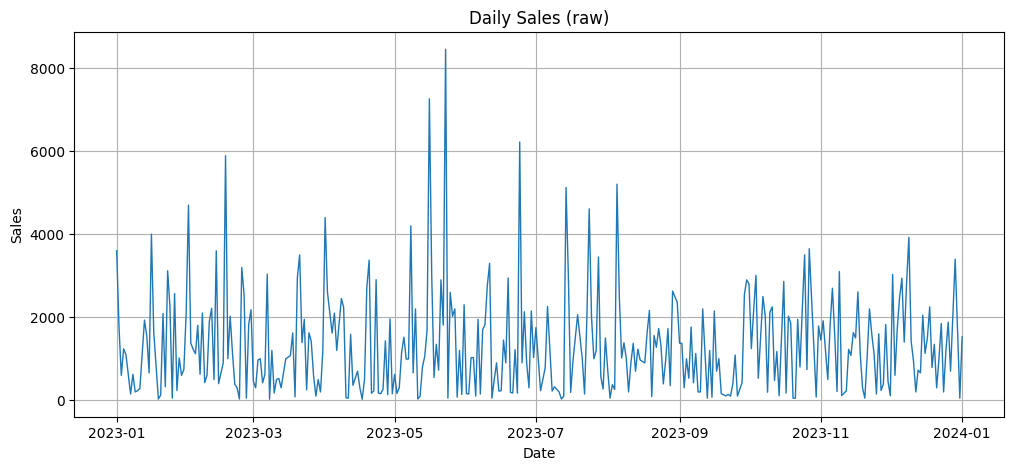

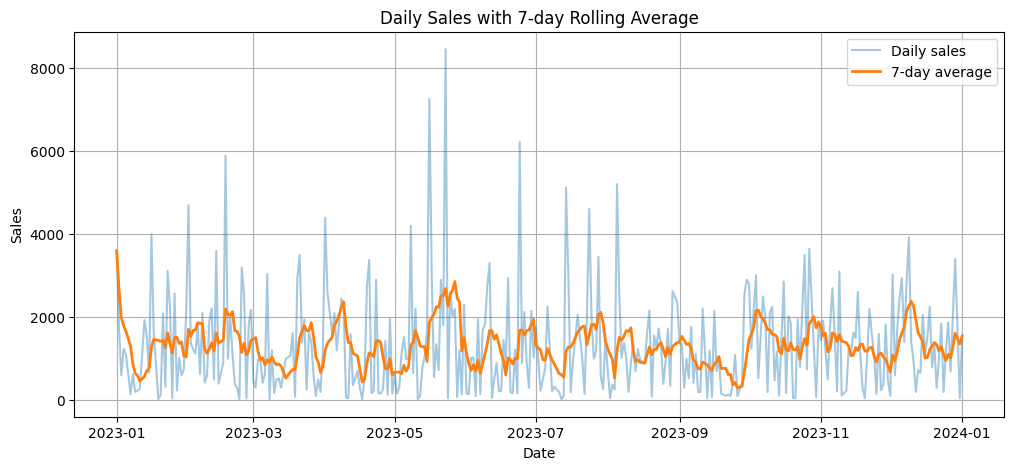

In [ ]:
# Cell 9 — Plot daily sales and 7-day rolling average
plt.figure()
plt.plot(daily['date'], daily['sales'], label='Daily sales', linewidth=1)
plt.title('Daily Sales (raw)')
plt.xlabel('Date'); plt.ylabel('Sales')
plt.grid(True)
plt.show()# ===============================
# Task 1 - Descriptive Statistics
# ===============================

# 1. Basic sales statistics
print("🔹 BASIC SALES STATISTICS")
print("Total Sales Amount:", data['Total Amount'].sum())
print("Average Sales per Transaction:", data['Total Amount'].mean())
print("Maximum Sales in a Transaction:", data['Total Amount'].max())
print("Minimum Sales in a Transaction:", data['Total Amount'].min())

# 2. Customer statistics
print("\n🔹 CUSTOMER STATISTICS")
print("Total Customers:", data['Customer ID'].nunique())
print("Average Age of Customers:", data['Age'].mean())

# 3. Gender contribution
print("\n🔹 SALES BY GENDER")
print(data.groupby('Gender')['Total Amount'].sum())

# 4. Top selling product categories
print("\n🔹 TOP 5 PRODUCT CATEGORIES BY SALES")
print(data.groupby('Product Category')['Total Amount'].sum().sort_values(ascending=False).head(5))

# 5. Average quantity purchased
print("\n🔹 AVERAGE QUANTITY PURCHASED PER TRANSACTION")
print(data['Quantity'].mean())

# 7-day rolling average (smoother trend)
daily['rolling_7d'] = daily['sales'].rolling(window=7, min_periods=1).mean()
plt.figure()
plt.plot(daily['date'], daily['sales'], alpha=0.4, label='Daily sales')
plt.plot(daily['date'], daily['rolling_7d'], linewidth=2, label='7-day average')
plt.title('Daily Sales with 7-day Rolling Average')
plt.xlabel('Date'); plt.ylabel('Sales')
plt.legend(); plt.grid(True)
plt.show()

Using DataFrame from variable: 'df'
Normalized columns: ['transaction_id', 'date', 'customer_id', 'gender', 'age', 'product_category', 'quantity', 'price_per_unit', 'total_amount']
Using date column: 'date' and sales column: 'total_amount'
Rows with invalid/unparsed dates: 0 (these will be dropped).

Monthly aggregated data (first 8 rows):


/tmp/ipython-input-3160913936.py:45: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data[date_col] = pd.to_datetime(data[date_col], errors='coerce', dayfirst=True, infer_datetime_format=True)


,year,month,sales,year_month
0,2023,1,35450,2023-01-01
1,2023,2,44060,2023-02-01
2,2023,3,28990,2023-03-01
3,2023,4,33870,2023-04-01
4,2023,5,53150,2023-05-01
5,2023,6,36715,2023-06-01
6,2023,7,35465,2023-07-01
7,2023,8,36960,2023-08-01



Monthly data summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   year        13 non-null     int32         
 1   month       13 non-null     int32         
 2   sales       13 non-null     int64         
 3   year_month  13 non-null     datetime64[ns]
dtypes: datetime64[ns](1), int32(2), int64(1)
memory usage: 444.0 bytes
None


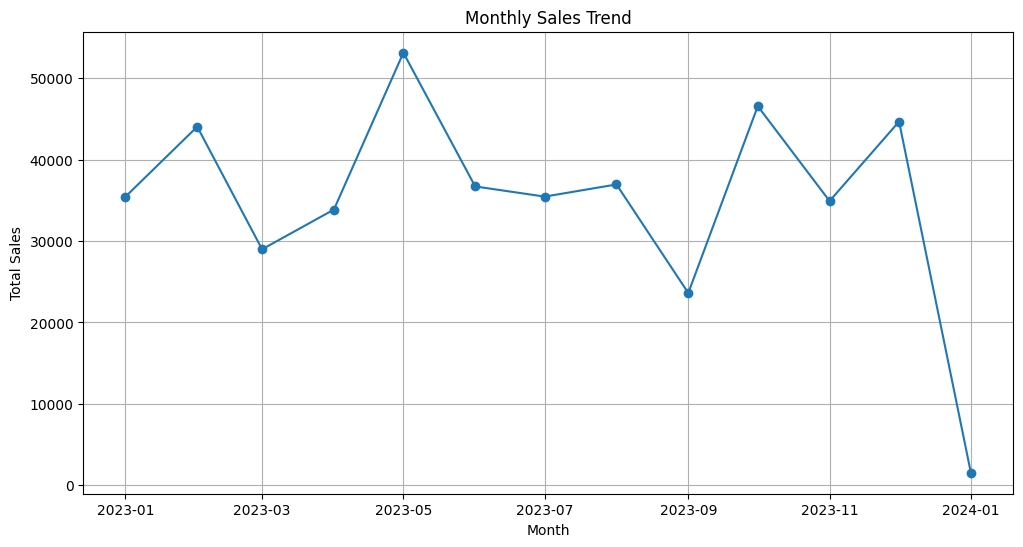


Top 3 months by sales:


,year,month,sales
4,2023,5,53150
9,2023,10,46580
11,2023,12,44690


In [ ]:
# Robust monthly-aggregation + plotting (auto-finds your DataFrame and columns)
import pandas as pd
import matplotlib.pyplot as plt
import re
from IPython.display import display

# 1) Find an existing DataFrame variable (tries common names)
candidate_vars = ['data','df','daily','retail_df','df1']
found = None
for name in candidate_vars:
    if name in globals() and isinstance(globals()[name], pd.DataFrame):
        data = globals()[name].copy()
        found = name
        print(f"Using DataFrame from variable: '{name}'")
        break

if found is None:
    raise NameError("Couldn't find your DataFrame. Make sure you ran the earlier cells so a DataFrame named 'df' or 'data' exists.")

# 2) Normalize column names to safe form
def normalize(col):
    col = str(col).strip()
    col = re.sub(r'\s+', ' ', col)
    col = re.sub(r'[^\w\s]', '', col)
    return col.lower().replace(' ', '_')

data.columns = [normalize(c) for c in data.columns]
print("Normalized columns:", list(data.columns))

# 3) Detect date column and sales column
date_col = next((c for c in data.columns if 'date' in c), None)
sales_candidates = ['total_amount','totalamount','total','sales','sales_amount','amount','revenue','price_per_unit','quantity']
sales_col = next((c for c in sales_candidates if c in data.columns), None)

if sales_col is None:
    # fallback: any column containing key words
    sales_col = next((c for c in data.columns if any(k in c for k in ['amount','total','sales','revenue','price','qty','quantity'])), None)

if date_col is None or sales_col is None:
    raise ValueError(f"Could not auto-detect date/sales columns.\nAvailable columns: {data.columns.tolist()}")

print(f"Using date column: '{date_col}' and sales column: '{sales_col}'")

# 4) Parse date column safely, drop bad rows
data[date_col] = pd.to_datetime(data[date_col], errors='coerce', dayfirst=True, infer_datetime_format=True)
bad = data[date_col].isna().sum()
print(f"Rows with invalid/unparsed dates: {bad} (these will be dropped).")
data = data.dropna(subset=[date_col]).sort_values(by=date_col).reset_index(drop=True)

# 5) Aggregate to monthly totals
data['year'] = data[date_col].dt.year
data['month'] = data[date_col].dt.month
monthly = (data.groupby(['year','month'], as_index=False)[sales_col]
             .sum()
             .rename(columns={sales_col: 'sales'}))
monthly['year_month'] = pd.to_datetime(monthly['year'].astype(str) + '-' + monthly['month'].astype(str) + '-01')

print("\nMonthly aggregated data (first 8 rows):")
display(monthly.head(8))
print("\nMonthly data summary:")
print(monthly.info())

# 6) Plot monthly sales trend
plt.figure(figsize=(12,6))
plt.plot(monthly['year_month'], monthly['sales'], marker='o')
plt.title('Monthly Sales Trend')
plt.xlabel('Month'); plt.ylabel('Total Sales'); plt.grid(True)
plt.show()

# 7) Print top 3 months by sales (for quick insight)
top3 = monthly.sort_values('sales', ascending=False).head(3)
print("\nTop 3 months by sales:")
display(top3[['year','month','sales']])

In [ ]:
pip install prophet

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

In [18]:
import pandas as pd

# Step 1: Load dataset (replace filename with your actual CSV/Excel file if different)
df = pd.read_csv("retail_sales_dataset.csv")

# Step 2: Ensure 'date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Step 3: Group by date and calculate daily sales
# (Make sure 'date' is in datetime format first)
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

daily = data.groupby(data['Date'].dt.date).agg({'Total Amount': 'sum'}).reset_index()
daily.rename(columns={'Date': 'Date', 'Total Amount': 'Total Amount'}, inplace=True)

# Step 4: Add 7-day rolling average
daily['Date'] = pd.to_datetime(daily['Date'])
daily['rolling_7d'] = daily['Total Amount'].rolling(window=7).mean()

# Show preview
daily.head(10)

# Step 5: Inspect first rows
print(daily.head())

        Date  Total Amount  rolling_7d
0 2023-01-01          3600         NaN
1 2023-01-02          1765         NaN
2 2023-01-03           600         NaN
3 2023-01-04          1240         NaN
4 2023-01-05          1100         NaN


/tmp/ipython-input-2204835237.py:7: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce')


In [19]:
# ===============================
# Task 1 - Descriptive Statistics
# ===============================

# 1. Basic sales statistics
print("🔹 BASIC SALES STATISTICS")
print("Total Sales Amount:", data['Total Amount'].sum())
print("Average Sales per Transaction:", data['Total Amount'].mean())
print("Maximum Sales in a Transaction:", data['Total Amount'].max())
print("Minimum Sales in a Transaction:", data['Total Amount'].min())

# 2. Customer statistics
print("\n🔹 CUSTOMER STATISTICS")
print("Total Customers:", data['Customer ID'].nunique())
print("Average Age of Customers:", data['Age'].mean())

# 3. Gender contribution
print("\n🔹 SALES BY GENDER")
print(data.groupby('Gender')['Total Amount'].sum())

# 4. Top selling product categories
print("\n🔹 TOP 5 PRODUCT CATEGORIES BY SALES")
print(data.groupby('Product Category')['Total Amount'].sum().sort_values(ascending=False).head(5))

# 5. Average quantity purchased
print("\n🔹 AVERAGE QUANTITY PURCHASED PER TRANSACTION")
print(data['Quantity'].mean())

🔹 BASIC SALES STATISTICS
Total Sales Amount: 456000
Average Sales per Transaction: 456.0
Maximum Sales in a Transaction: 2000
Minimum Sales in a Transaction: 25

🔹 CUSTOMER STATISTICS
Total Customers: 1000
Average Age of Customers: 41.392

🔹 SALES BY GENDER
Gender
Female    232840
Male      223160
Name: Total Amount, dtype: int64

🔹 TOP 5 PRODUCT CATEGORIES BY SALES
Product Category
Electronics    156905
Clothing       155580
Beauty         143515
Name: Total Amount, dtype: int64

🔹 AVERAGE QUANTITY PURCHASED PER TRANSACTION
2.514


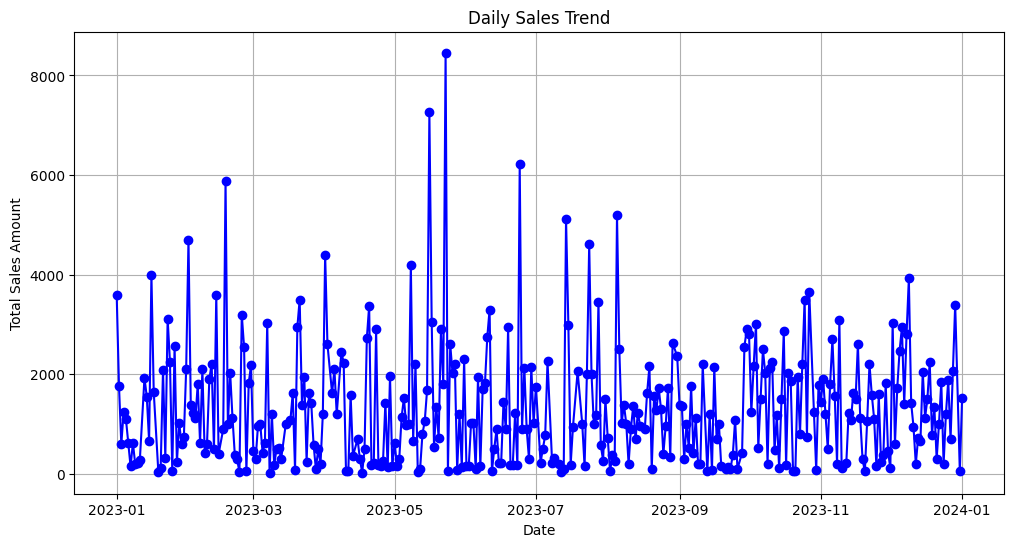

In [20]:
# Step 1: Convert 'Date' to datetime
data['Date'] = pd.to_datetime(data['Date'], errors='coerce', dayfirst=True)

# Step 2: Group by Date to calculate daily sales
daily_sales = data.groupby('Date', as_index=False)['Total Amount'].sum()

# Step 3: Plot Daily Sales Trend
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(daily_sales['Date'], daily_sales['Total Amount'], marker='o', linestyle='-', color='blue')
plt.title("Daily Sales Trend")
plt.xlabel("Date")
plt.ylabel("Total Sales Amount")
plt.grid(True)
plt.show()

In [21]:
!pip install prophet

In [22]:
from prophet import Prophet

# Prepare data for Prophet
df_prophet = df.groupby("Date")["Total Amount"].sum().reset_index()
df_prophet.rename(columns={"Date": "ds", "Total Amount": "y"}, inplace=True)

print(df_prophet.head())

          ds     y
0 2023-01-01  3600
1 2023-01-02  1765
2 2023-01-03   600
3 2023-01-04  1240
4 2023-01-05  1100


In [23]:
# Initialize and fit Prophet model
model = Prophet()
model.fit(df_prophet)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8p0so_d9/aknkajm7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8p0so_d9/m8k62016.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65363', 'data', 'file=/tmp/tmp8p0so_d9/aknkajm7.json', 'init=/tmp/tmp8p0so_d9/m8k62016.json', 'output', 'file=/tmp/tmp8p0so_d9/prophet_modelnk7wse1v/prophet_model-20250830132625.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:26:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:26:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Create future dataframe (next 30 days)
future = model.make_future_dataframe(periods=30)

# Predict future sales
forecast = model.predict(future)

# Show forecasted values
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
370,2024-01-27,1610.623558,-13.553394,3115.278437
371,2024-01-28,1128.745005,-412.113056,2681.533067
372,2024-01-29,1380.274601,-136.783021,2963.278444
373,2024-01-30,1419.963989,-141.873465,3006.466485
374,2024-01-31,1281.212636,-287.373213,2884.920299


In [25]:
from prophet.plot import plot_plotly

fig = plot_plotly(model, forecast)
fig.show()